In [0]:
# Load Required Libraries
# This model acts as Pre Loan Default Screener (Model without Loan Underwriter Inputs)
# int_Rate and Loan Grade are Removed from this model
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

import seaborn as sns   # Heatmap plot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Algorithm Models to import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# All performance Metrics
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the re

In [0]:
# Plotting Sub-function to display Performance Metrics
def Plot_Precision_Recall_Curve(precision, recall,averagePrecision):
    plt.clf()
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          averagePrecision))
    plt.show()

def plot_TrainTestAccuracy(xs, train_accuracy_list, dev_accuracy_list):
    plt.clf()
    plt.plot(xs, train_accuracy_list, label='train')
    plt.plot(xs, dev_accuracy_list, label='dev')
    plt.xlabel('Tuning Parameter')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_PrecisionRecall(xs, dev_precision_list, dev_recall_list):
    plt.clf()
    plt.plot(xs, dev_precision_list, label='Precision')
    plt.plot(xs, dev_recall_list, label='recall')
    plt.ylabel('Precision and Recall')
    plt.xlabel(' Tuning Parameter')
    plt.legend()
    plt.show() 

def plot_AUCROCCurve(fpr,tpr,AUC):
    plt.clf()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic' + str(AUC))
    plt.legend(loc="lower right")
    plt.show()    

def plot_kscurve(fpr,tpr):    
    plt.clf()    
    plt.plot([0,1,2,3,4,5,6,7,8,9,10],np.percentile(tpr,[0,10,20,30,40,50,60,70,80,90,100]),color = 'r')
    plt.plot([0,1,2,3,4,5,6,7,8,9,10],np.percentile(fpr,[0,10,20,30,40,50,60,70,80,90,100]), color='navy', linestyle='--')
    plt.title('KS='+str(np.max(tpr - fpr)))
    plt.xlabel('quantile')
    plt.ylabel('FPR or TPR')
    plt.legend(('TPR','FPR'))
    plt.grid()    
    
# Get Error Type
def get_error_type(pred, label):
    # return the type of error: tp,fp,tn,fn
    if pred == label:
        return "tp" if pred == 1 else "tn"
    return "fp" if pred == 1 else "fn"    

# Custom function to get confusion Matrix     
def get_custom_confusionMatrix(predicted, truelabel):
    confusion_mat = np.zeros((2, 2))
    
    for k in range(0,len(predicted)):
        val = get_error_type(predicted[k], truelabel[k])
        if val == "tp":     
            confusion_mat[0][0] = confusion_mat[0][0] + 1
        elif val == "fp":     
            confusion_mat[0][1] = confusion_mat[0][1] + 1
        elif val == "fn":         
            confusion_mat[1][0] = confusion_mat[1][0] + 1
        else:
            confusion_mat[1][1] = confusion_mat[1][1] + 1
            
    return(confusion_mat)             

In [0]:
# Read Dataset csv file 
rawdataset = pd.read_csv('dataset2\dataset.csv')

In [0]:
# Retraining dataset with "Current" and "Late 16-30 days" as loan status
retrainingdataset = pd.DataFrame(rawdataset)
rawdataset = pd.DataFrame(rawdataset)

retrainingdataset = retrainingdataset[retrainingdataset.loan_status != 'Charged Off']
retrainingdataset = retrainingdataset[retrainingdataset.loan_status != 'Default']
retrainingdataset = retrainingdataset[retrainingdataset.loan_status != 'Fully Paid']
retrainingdataset = retrainingdataset[retrainingdataset.loan_status != 'Late (31-120 days)']

# Remove all data with "Current" and "Late 16-30 days" as loan status
rawdataset = rawdataset[rawdataset.loan_status != 'Current']
rawdataset = rawdataset[rawdataset.loan_status != 'Late (16-30 days)']

print(len(rawdataset))
print(len(retrainingdataset))

265780
604134


In [0]:
# Define Target Variable
# Fully paid or Current means 0 Rest categories as 1 (Default)
columnsTarget = ['loan_status']
subset_Target = pd.DataFrame(rawdataset,columns=columnsTarget)

label_encoder   = LabelEncoder()
integer_encoded = label_encoder.fit_transform(subset_Target)

for k in range(0,max(integer_encoded)+1):
    print("Interger Encoded:", k, label_encoder.inverse_transform(k))

TargetVar = []
for k in range(0,len(integer_encoded)):
    tempvar = 1
    if integer_encoded[k] == 2 :   # Fully Paid
        tempvar = 0
    TargetVar.append(tempvar)

Interger Encoded: 0 Charged Off
Interger Encoded: 1 Default
Interger Encoded: 2 Fully Paid
Interger Encoded: 3 Late (31-120 days)


C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\bchandrasekaran\AppData\Local\Continuum\Anaconda3\lib\site-packages

In [0]:
# Create sub-frame organized data

# Character Catergory subset
columnscharacter = ['delinq_2yrs','inq_last_6mths','open_acc','revol_bal','revol_util', 'tot_cur_bal', 'collections_12_mths_ex_med', 'earliest_cr_line_elapseddays']   
# Conditions Cateory subset
columnscond       = ['loan_amnt','term','purpose']
# capacity Cateory subset
columnscapactity  = ['emp_length','annual_inc_merged','dti_merged']
# Collateral Category subset
columnscollateral = ['home_ownership']

columns_sub = columnscharacter
columns_sub.extend(columnscapactity)
columns_sub.extend(columnscollateral)
columns_sub.extend(columnscond)

subsetdf    = pd.DataFrame(rawdataset,columns=columns_sub)

print(subsetdf.dtypes)

# Fill Null Values with Mean
for col in subsetdf.columns:
    if subsetdf[col].dtype == np.float64 or subsetdf[col].dtype == np.int64 :
        if subsetdf[col].isnull().sum(axis=0) > 0 :
            meanval = subsetdf[col].mean()
            subsetdf[col] = subsetdf[col].fillna(meanval,inplace=False)

# Replace Home Ownership into Collateral Possible 
subsetdf['home_ownership'].replace(to_replace='OWN', value='COLLPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='MORTGAGE', value='COLLPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='RENT', value='COLLNOTPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='OTHER', value='COLLNOTPOSSIBLE', regex=True, inplace=True)
subsetdf['home_ownership'].replace(to_replace='NONE', value='COLLNOTPOSSIBLE', regex=True, inplace=True)


# Encode all Catrgorical Variables
subsetdf = pd.get_dummies(subsetdf,columns=['home_ownership'])
subsetdf = pd.get_dummies(subsetdf,columns=['term'])
subsetdf = pd.get_dummies(subsetdf,columns=['purpose'])

# Create Normalized data frame
subsetdf_Normalized = subsetdf

# Add Target Variable
target_series = pd.Series(TargetVar)
target_series.index = subsetdf.index


# Normalize Dataset (Mean and std)
for col in subsetdf_Normalized:
    if subsetdf_Normalized[col].dtype == np.float64 or subsetdf_Normalized[col].dtype == np.int64 :
        meanval = np.mean(subsetdf_Normalized[col])
        stdval  = np.std(subsetdf_Normalized[col])  
        subsetdf_Normalized[col] = (subsetdf_Normalized[col] - meanval)/stdval

# Add Target Variable
target_series = pd.Series(TargetVar)
target_series.index = subsetdf_Normalized.index
subsetdf_Normalized['TARGET'] = target_series

delinq_2yrs                       int64
inq_last_6mths                    int64
open_acc                          int64
revol_bal                         int64
revol_util                      float64
tot_cur_bal                     float64
collections_12_mths_ex_med      float64
earliest_cr_line_elapseddays      int64
emp_length                        int64
annual_inc_merged               float64
dti_merged                      float64
home_ownership                   object
loan_amnt                         int64
term                             object
purpose                          object
dtype: object


In [0]:
# prep data for adding back to retraining (from Current and Late 16-31 days)
subsetretrain    = pd.DataFrame(retrainingdataset,columns=columns_sub)

# Fill Null Values with Mean
for col in subsetretrain.columns:
    if subsetretrain[col].dtype == np.float64 or subsetretrain[col].dtype == np.int64 :
        if subsetretrain[col].isnull().sum(axis=0) > 0 :
            meanval = subsetretrain[col].mean()
            subsetretrain[col] = subsetretrain[col].fillna(meanval,inplace=False)

# Replace Home Ownership into Collateral Possible 
subsetretrain['home_ownership'].replace(to_replace='OWN', value='COLLPOSSIBLE', regex=True, inplace=True)
subsetretrain['home_ownership'].replace(to_replace='MORTGAGE', value='COLLPOSSIBLE', regex=True, inplace=True)
subsetretrain['home_ownership'].replace(to_replace='RENT', value='COLLNOTPOSSIBLE', regex=True, inplace=True)
subsetretrain['home_ownership'].replace(to_replace='OTHER', value='COLLNOTPOSSIBLE', regex=True, inplace=True)
subsetretrain['home_ownership'].replace(to_replace='NONE', value='COLLNOTPOSSIBLE', regex=True, inplace=True)
            
# Encode all Catrgorical Variables
subsetretrain = pd.get_dummies(subsetretrain,columns=['home_ownership'])
subsetretrain = pd.get_dummies(subsetretrain,columns=['term'])
subsetretrain = pd.get_dummies(subsetretrain,columns=['purpose'])

# Create Normalized data frame
subsetretrain_Normalized = subsetretrain

# Normalize Dataset (Mean and std)
for col in subsetretrain_Normalized:
    if subsetretrain_Normalized[col].dtype == np.float64 or subsetretrain_Normalized[col].dtype == np.int64 :
        meanval = np.mean(subsetretrain_Normalized[col])
        stdval  = np.std(subsetretrain_Normalized[col])  
        subsetretrain_Normalized[col] = (subsetretrain_Normalized[col] - meanval)/stdval
        
# Iterate each column of Numerical data and Find Number of Null Values in 
totalcols = len(subsetretrain_Normalized)
for col in subsetretrain_Normalized.columns:
    percentageempty = subsetretrain_Normalized[col].isnull().sum(axis=0) / totalcols
    print (col,subsetretrain_Normalized[col].isnull().sum(axis=0),percentageempty)

delinq_2yrs 0 0.0
inq_last_6mths 0 0.0
open_acc 0 0.0
revol_bal 0 0.0
revol_util 0 0.0
tot_cur_bal 0 0.0
collections_12_mths_ex_med 0 0.0
earliest_cr_line_elapseddays 0 0.0
emp_length 0 0.0
annual_inc_merged 0 0.0
dti_merged 0 0.0
loan_amnt 0 0.0
home_ownership_COLLNOTPOSSIBLE 0 0.0
home_ownership_COLLPOSSIBLE 0 0.0
term_ 36 months 0 0.0
term_ 60 months 0 0.0
purpose_car 0 0.0
purpose_credit_card 0 0.0
purpose_debt_consolidation 0 0.0
purpose_educational 0 0.0
purpose_home_improvement 0 0.0
purpose_house 0 0.0
purpose_major_purchase 0 0.0
purpose_medical 0 0.0
purpose_moving 0 0.0
purpose_other 0 0.0
purpose_renewable_energy 0 0.0
purpose_small_business 0 0.0
purpose_vacation 0 0.0
purpose_wedding 0 0.0


In [0]:
# Handle imbalanced data
subsetdf_Target0 = subsetdf_Normalized[subsetdf_Normalized.TARGET == 0]
subsetdf_Target1 = subsetdf_Normalized[subsetdf_Normalized.TARGET == 1]

itemstodrop = (len(subsetdf_Normalized.TARGET)) - np.sum(subsetdf_Normalized.TARGET)

itemstodrop = int(itemstodrop/2)

#print(len(subsetdf_Normalized.TARGET))
#print(itemstodrop)
#print(len(subsetdf_Target0))

indextodrop = np.random.permutation(itemstodrop)
subsetdf_Target0 = subsetdf_Target0.drop(subsetdf_Target0.index[indextodrop],axis='rows')


frames = [subsetdf_Target0, subsetdf_Target1]
subsetdf_Normalized2 = pd.concat(frames)



In [0]:
# Drop Target Variavle from input parameter   
y = subsetdf_Normalized2['TARGET'].values     # Output Target
subsetdf_Normalized2 = subsetdf_Normalized2.drop(['TARGET'],axis=1)
train_x, test_x,train_y, test_y = train_test_split(subsetdf_Normalized2,y,test_size = 0.2, random_state  = 42)

print(len(train_x))
print(len(test_x))

129535
32384


In [0]:
print(train_x.shape)

(129535, 30)


In [0]:
print(train_x.shape)

(129535, 30)


In [0]:
# Fine Tuned Gradient Boosting Classifier (Best Performing Gradient Boosting Classifier) 
gbm_tuned_Best = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=9, min_samples_split=1800, min_samples_leaf=30, subsample=0.9, random_state=10, max_features=30,
warm_start=True)

gbm_tuned_Best.fit(train_x, train_y.ravel())

train_preds = gbm_tuned_Best.predict(train_x)
dev_preds_GBM   = gbm_tuned_Best.predict(test_x)

# Analyze Tuned Model Performance in Testing and Development Datasets
(train_score, dev_score) = (accuracy_score(train_y, train_preds), accuracy_score(test_y, dev_preds_GBM))
    


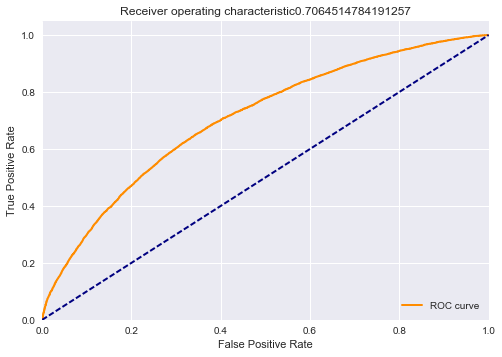

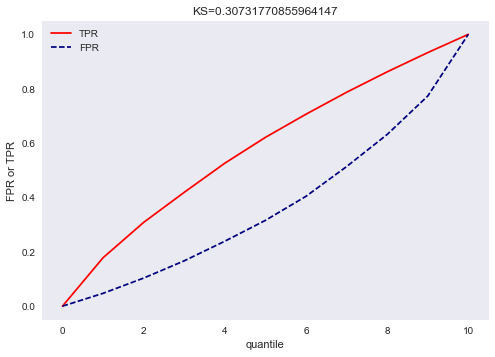

In [0]:
dev_preds_GBM_Proba  = gbm_tuned_Best.predict_proba(test_x)
fpr,tpr,_ = roc_curve(test_y, dev_preds_GBM_Proba[:,1], pos_label= 1)
plot_AUCROCCurve(fpr,tpr,roc_auc_score(test_y,dev_preds_GBM_Proba[:,1]))
plot_kscurve(fpr,tpr)

In [0]:
# Find Recall and Precision Scores  
train_score_r = recall_score(train_y, train_preds, pos_label=1, average="binary")
train_score_p = precision_score(train_y, train_preds, pos_label=1, average="binary")
    
dev_score_r = recall_score(test_y, dev_preds_GBM, pos_label=1, average="binary")
dev_score_p = precision_score(test_y, dev_preds_GBM, pos_label=1, average="binary")
    
print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score)
print("Train Recall:", train_score_r, ", Train Precision:", train_score_p)
print("Dev Recall:", dev_score_r, ", Dev Precision:", dev_score_p)

print("AUC Score")
print (roc_auc_score(test_y,dev_preds_GBM_Proba[:,1]))
AUC = roc_auc_score(test_y,dev_preds_GBM_Proba[:,1])
print(AUC)


# Print Confusion Matrix for Performance Analysis
cfmatrix = get_custom_confusionMatrix(dev_preds_GBM,test_y.ravel())
print(cfmatrix)
print("tp:", int(cfmatrix[0][0]), ", fp:", int(cfmatrix[0][1]),", fn:", int(cfmatrix[1][0]),", tn:", int(cfmatrix[1][1]))


Train Accuracy: 0.7079090593275948 , Dev Accuracy: 0.6833621541501976
Train Recall: 0.3751351585139051 , Train Precision: 0.6598828362751065
Dev Recall: 0.3491875423155044 , Dev Precision: 0.6167414050822122
AUC Score
0.7064514784191257
0.7064514784191257
[[ 4126.  2564.]
 [ 7690. 18004.]]
tp: 4126 , fp: 2564 , fn: 7690 , tn: 18004


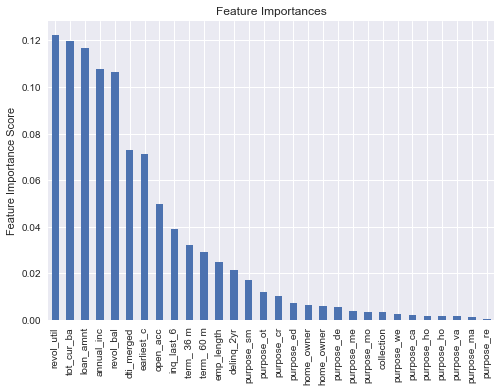

In [0]:
# Plot Feature Importance from Gradien Boosting Classifier
UnsortedNames = []
for col in train_x.columns:
    UnsortedNames.append(col[0:10])
#print(UnsortedNames)

#Print Feature Importance:
feat_imp = pd.Series(gbm_tuned_Best.feature_importances_, UnsortedNames).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

plt.savefig('FeatureImportance-GB.png')


Train Accuracy: 0.9791793723704019 , Dev Accuracy: 0.6378458498023716 ,param: 10
Train Recall: 0.9447039487911423 , Train Precision: 0.9968054763262978 ,param: 10
Dev Recall: 0.2514387271496276 , Dev Precision: 0.5075162282200205 ,param: 10
Train Accuracy: 0.9996371637009303 , Dev Accuracy: 0.6538414031620553 ,param: 35
Train Recall: 0.999048484062108 , Train Precision: 0.9999350663405554 ,param: 35
Dev Recall: 0.2916384563303995 , Dev Precision: 0.5482023544384346 ,param: 35
Train Accuracy: 0.9999768402362296 , Dev Accuracy: 0.6576395750988142 ,param: 60
Train Recall: 0.9999351239133255 , Train Precision: 1.0 ,param: 60
Dev Recall: 0.26337169939065674 , Dev Precision: 0.5663330300272975 ,param: 60
Train Accuracy: 0.9999922800787432 , Dev Accuracy: 0.6593379446640316 ,param: 85
Train Recall: 0.9999783746377752 , Train Precision: 1.0 ,param: 85
Dev Recall: 0.2753893026404875 , Dev Precision: 0.5684835779175402 ,param: 85
Train Accuracy: 1.0 , Dev Accuracy: 0.6591526679841897 ,param: 110

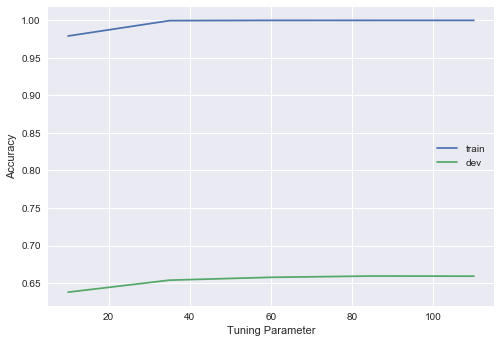

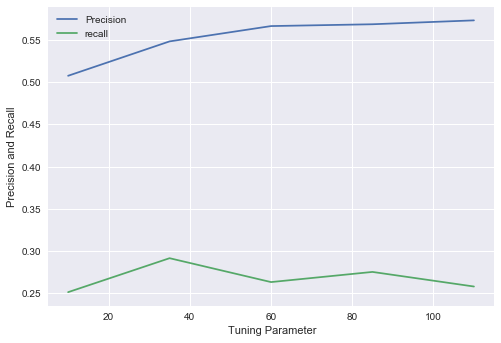

In [0]:
# Try Random Forest Algorithm and Pick the best Parameter based on dev dataset
cs = np.arange(10, 130, 25)

train_accuracy_list = list()
dev_accuracy_list = list()

dev_recall_list = list()
dev_precision_list = list()
dev_f1score_list = list()

for c in cs:
    model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',n_estimators = c)
    model.fit(train_x,train_y)
    train_preds = model.predict(train_x)
    dev_preds   = model.predict(test_x)

    (train_score, dev_score) = (accuracy_score(train_y, train_preds), accuracy_score(test_y, dev_preds))
    
    # Find Recall and Precision Scores  
    train_score_r = recall_score(train_y, train_preds, pos_label=1, average="binary")
    train_score_p = precision_score(train_y, train_preds, pos_label=1, average="binary")
    
    dev_score_r = recall_score(test_y, dev_preds, pos_label=1, average="binary")
    dev_score_p = precision_score(test_y, dev_preds, pos_label=1, average="binary")
    dev_f1score = f1_score(test_y, dev_preds, pos_label=1, average="binary")
    
    # Collect Train and Dev Accuracy
    train_accuracy_list.append(train_score)
    dev_accuracy_list.append(dev_score)
    
    # Collect dev Precision and Recall 
    dev_recall_list.append(dev_score_r)
    dev_precision_list.append(dev_score_p)
    dev_f1score_list.append(dev_f1score)
    
    print("Train Accuracy:", train_score, ", Dev Accuracy:", dev_score, ",param:", c)
    print("Train Recall:", train_score_r, ", Train Precision:", train_score_p, ",param:", c)
    print("Dev Recall:", dev_score_r, ", Dev Precision:", dev_score_p, ",param:", c)

# Plot Train, Test Accuracy; Test set Precision and Recall scores
plot_TrainTestAccuracy(cs, train_accuracy_list, dev_accuracy_list)
plot_PrecisionRecall(cs,dev_precision_list, dev_recall_list)

Best Model Random Forest Algorithm Performance :
Dev Recall: 0.29536222071767093 , Dev Precision: 0.5502128330443008 ,Accuracy: 0.6547986660079052
AUC Score
0.646564557511165
[[ 3490.  2853.]
 [ 8326. 17715.]]
tp: 3490 , fp: 2853 , fn: 8326 , tn: 17715


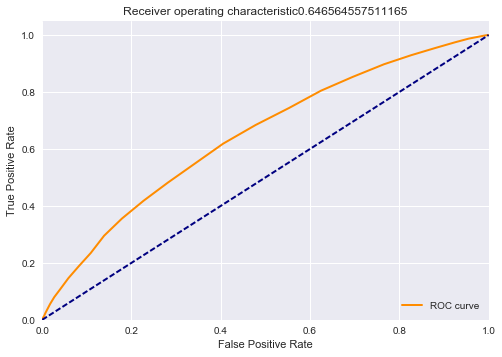

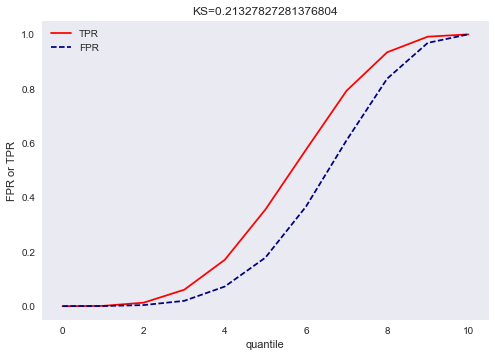

In [0]:
# Pick the Performance Parameter
#best_model_RF = RandomForestClassifier(n_estimators = cs[np.argmax(dev_accuracy_list)])  
best_model_RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', n_estimators = cs[np.argmax(dev_f1score_list)])
best_model_RF.fit(train_x,train_y)
dev_preds_RF  = best_model_RF.predict(test_x)

dev_preds_RF_Proba = best_model_RF.predict_proba(test_x)

print("Best Model Random Forest Algorithm Performance :")

dev_accuracy_RF = accuracy_score(test_y, dev_preds_RF)
dev_score_r_RF  = recall_score(test_y, dev_preds_RF, pos_label=1, average="binary")
dev_score_p_RF  = precision_score(test_y, dev_preds_RF, pos_label=1, average="binary")
print("Dev Recall:", dev_score_r_RF, ", Dev Precision:", dev_score_p_RF, ",Accuracy:", dev_accuracy_RF)

print("AUC Score")
AUC = roc_auc_score(test_y,dev_preds_RF_Proba[:,1])
print(AUC)

# Print Confusion Matrix for Performance Analysis
cfmatrix = get_custom_confusionMatrix(dev_preds_RF,test_y.ravel())
print(cfmatrix)
print("tp:", int(cfmatrix[0][0]), ", fp:", int(cfmatrix[0][1]),", fn:", int(cfmatrix[1][0]),", tn:", int(cfmatrix[1][1]))

# Print ks curve and AUC curve
fpr,tpr,_ = roc_curve(test_y, dev_preds_RF_Proba[:,1], pos_label= 1)
plot_AUCROCCurve(fpr,tpr,roc_auc_score(test_y,dev_preds_RF_Proba[:,1]))
plot_kscurve(fpr,tpr)

In [0]:
# Code to Retrain with best Model Estimate (Add Samples with High Confidence probabilities from Current Dataset)
retrain_predProb_RF   = gbm_tuned_Best.predict_proba(subsetretrain_Normalized)
retrain_prediction_RF = gbm_tuned_Best.predict(subsetretrain_Normalized)








In [0]:
retrain_zero_index = []
retrain_one_index = []

# Selection High Confidence Values and use for retraining Model
for k in range(0,len(retrain_prediction_RF)):
    if retrain_prediction_RF[k] == 0 and retrain_predProb_RF[k,0] >= 0.80 :
        retrain_zero_index.append(k)
    elif retrain_prediction_RF[k] == 1 and retrain_predProb_RF[k,1] >= 0.80 :         
        retrain_one_index.append(k)


In [0]:
# Extract High Confidence Values for Combining   
retrain_zerovals = pd.DataFrame(subsetretrain_Normalized.iloc[retrain_zero_index])

TargetVar     = np.zeros(len(retrain_zero_index))
target_series = pd.Series(TargetVar)
target_series.index = retrain_zerovals.index
retrain_zerovals['TARGET'] = target_series

retrain_onevals = pd.DataFrame(subsetretrain_Normalized.iloc[retrain_one_index])
TargetVar     = np.ones(len(retrain_one_index))
target_series = pd.Series(TargetVar)
target_series.index = retrain_onevals.index
retrain_onevals['TARGET'] = target_series

frames = [retrain_zerovals, retrain_onevals]
subsetdf_Normalized_retrainadded = pd.concat(frames)

# Iterate each column of Numerical data and Find Number of Null Values in 
totalcols = len(subsetdf_Normalized_retrainadded)
for col in subsetdf_Normalized_retrainadded.columns:
    percentageempty = subsetdf_Normalized_retrainadded[col].isnull().sum(axis=0) / totalcols
    print (col,subsetdf_Normalized_retrainadded[col].isnull().sum(axis=0),percentageempty)

delinq_2yrs 0 0.0
inq_last_6mths 0 0.0
open_acc 0 0.0
revol_bal 0 0.0
revol_util 0 0.0
tot_cur_bal 0 0.0
collections_12_mths_ex_med 0 0.0
earliest_cr_line_elapseddays 0 0.0
emp_length 0 0.0
annual_inc_merged 0 0.0
dti_merged 0 0.0
loan_amnt 0 0.0
home_ownership_COLLNOTPOSSIBLE 0 0.0
home_ownership_COLLPOSSIBLE 0 0.0
term_ 36 months 0 0.0
term_ 60 months 0 0.0
purpose_car 0 0.0
purpose_credit_card 0 0.0
purpose_debt_consolidation 0 0.0
purpose_educational 0 0.0
purpose_home_improvement 0 0.0
purpose_house 0 0.0
purpose_major_purchase 0 0.0
purpose_medical 0 0.0
purpose_moving 0 0.0
purpose_other 0 0.0
purpose_renewable_energy 0 0.0
purpose_small_business 0 0.0
purpose_vacation 0 0.0
purpose_wedding 0 0.0
TARGET 0 0.0


In [0]:
# Drop Target Variavle from input parameter   (Use this for handling imbalanced data)
y_retrainadded = subsetdf_Normalized_retrainadded['TARGET'].values            # Output Target
subsetdf_Normalized_retrainadded = subsetdf_Normalized_retrainadded.drop(['TARGET'],axis=1)

#train_x1, test_x1,train_y1, test_y1 = train_test_split(subsetdf_Normalized_retrainadded,y_retrainadded,test_size = 0.1)
train_xnew, test_xnew,train_ynew, test_ynew = train_test_split(subsetdf_Normalized_retrainadded,y_retrainadded,test_size = 0.289, random_state  = 42)

datasettrain   = train_x.values
datasetretrain = train_xnew.values

print(datasettrain.shape)
print(datasetretrain.shape)

train_x1 = np.concatenate((datasettrain,datasetretrain), axis=0)
print(train_x1.shape)

train_y1 = np.concatenate((train_y.ravel(),train_ynew.ravel()), axis=0)
print(train_y1.shape)



(129535, 30)
(85990, 30)
(215525, 30)
(215525,)


Final Best Model Performance :
Train Recall: 0.368993555642057 , Train Precision: 0.6548085041062246 ,Accuracy: 0.7052997259427953
Dev Recall: 0.3464793500338524 , Dev Precision: 0.6158243080625753 ,Accuracy: 0.6826828063241107
AUC Score
0.7051026778883894
[[ 4094.  2554.]
 [ 7722. 18014.]]
tp: 4094 , fp: 2554 , fn: 7722 , tn: 18014


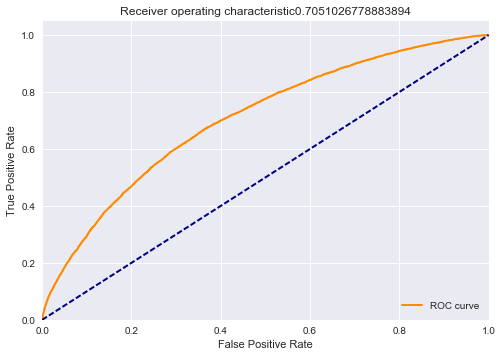

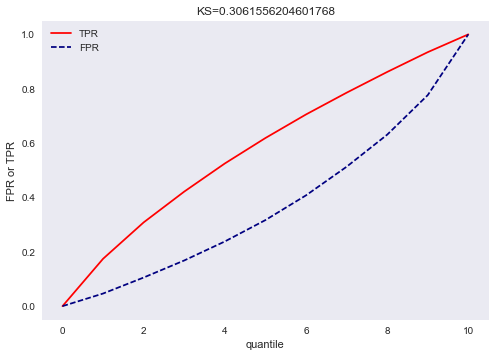

In [0]:
# Final Train and See Results

# Fine Tuned Gradient Boosting Classifier (Best Performing Gradient Boosting Classifier) 
gbm_tuned_Best_Final = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=9, min_samples_split=1800, min_samples_leaf=22, subsample=0.9, random_state=10, max_features=30,
warm_start=True)

gbm_tuned_Best_Final.fit(train_x1, train_y1.ravel())

train_preds         = gbm_tuned_Best_Final.predict(train_x)
dev_preds_GBM_Final   = gbm_tuned_Best_Final.predict(test_x)

dev_preds_GBM_Final_Proba   = gbm_tuned_Best_Final.predict_proba(test_x)


# Analyze Tuned Model Performance in Testing and Development Datasets
(train_score, dev_score) = (accuracy_score(train_y, train_preds), accuracy_score(test_y, dev_preds_GBM_Final))

print("Final Best Model Performance :")


train_score_r_GBF  = recall_score(train_y, train_preds, pos_label=1, average="binary")
train_score_p_GBF  = precision_score(train_y, train_preds, pos_label=1, average="binary")
print("Train Recall:", train_score_r_GBF, ", Train Precision:", train_score_p_GBF, ",Accuracy:", train_score)


dev_accuracy_GBF = accuracy_score(test_y, dev_preds_GBM_Final)
dev_score_r_GBF  = recall_score(test_y, dev_preds_GBM_Final, pos_label=1, average="binary")
dev_score_p_GBF  = precision_score(test_y, dev_preds_GBM_Final, pos_label=1, average="binary")
print("Dev Recall:", dev_score_r_GBF, ", Dev Precision:", dev_score_p_GBF, ",Accuracy:", dev_accuracy_GBF)

print("AUC Score")
AUC = roc_auc_score(test_y,dev_preds_GBM_Final_Proba[:,1])
print(AUC)

# Print Confusion Matrix for Performance Analysis
cfmatrix = get_custom_confusionMatrix(dev_preds_GBM_Final,test_y.ravel())
print(cfmatrix)
print("tp:", int(cfmatrix[0][0]), ", fp:", int(cfmatrix[0][1]),", fn:", int(cfmatrix[1][0]),", tn:", int(cfmatrix[1][1]))

# plot AUC and KS Score
fpr,tpr,_ = roc_curve(test_y, dev_preds_GBM_Final_Proba[:,1])
plot_AUCROCCurve(fpr,tpr,roc_auc_score(test_y,dev_preds_GBM_Final_Proba[:,1]))
plot_kscurve(fpr,tpr)
